In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [2]:
h, w = 160, 160

x_train=[]
y_train=[]
x_test=[]
y_test=[]

path_train_low='../../dataSets/ref/our485/low/'
path_train_high='../../dataSets/ref/our485/high/'
path_test_low='../../dataSets/ref/eval15/low/'
path_test_high='../../dataSets/ref/eval15/high/'

print('\nLoding Train dataset :')
i=0;
for img in os.listdir(path_train_low):
    img_low_path=os.path.join(path_train_low, img)
    img_high_path=os.path.join(path_train_high, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
    
    i=i+1
    print("{:.2f}".format(i/4.89)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(h,w))
    img_high=img_to_array(img_high)/255.
    
    x_train.append(img_low)
    y_train.append(img_high)
    
print('\nLoding Test dataset :')
i=0;
for img in os.listdir(path_test_low):
    img_low_path=os.path.join(path_test_low, img)
    img_high_path=os.path.join(path_test_high, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
    
    i=i+1
    print("{:.2f}".format(i/0.14)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(h,w))
    img_high=img_to_array(img_high)/255.
    
    x_test.append(img_low)
    y_test.append(img_high)

x_train=np.array(x_train, dtype="float32")
y_train=np.array(y_train, dtype="float32")

x_test=np.array(x_test, dtype="float32")
y_test=np.array(y_test, dtype="float32")


Loding Train dataset :
100.00 %
Loding Test dataset :


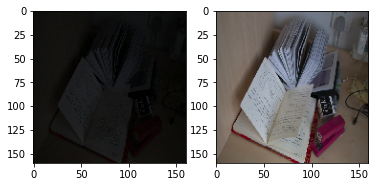

In [3]:
fig=plt.figure()

f=fig.add_subplot(1,2,1)
s=fig.add_subplot(1,2,2)

f.imshow(x_test[6])
s.imshow(y_test[6])

## PSNR 

In [11]:
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def PSNR_avg(target, pred):
    psnr_avg = 0
    for i in range(pred.shape[0]):
        psnr_avg = psnr_avg + PSNR(target[i], pred[i])
    psnr_avg = psnr_avg / pred.shape[0]
    return psnr_avg

## SSIM

In [5]:
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2)),
                        (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                            (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def SSIM_avg(y_true, y_pred):
    return (tf_ssim(tf.expand_dims(y_pred[:, :, :, 0], -1),tf.expand_dims(y_true[:, :, :, 0], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 1], -1), tf.expand_dims(y_true[:, :, :, 1], -1)) + tf_ssim(
                tf.expand_dims(y_pred[:, :, :, 2], -1), tf.expand_dims(y_true[:, :, :, 2], -1)))/3

## NIQE

In [12]:
print(PSNR_avg(y_test, x_test))
print(PSNR_avg(y_test, y_test))

7.448685896840084
100.0


In [10]:
print(SSIM_avg(y_test, x_test))
print(SSIM_avg(y_test, y_test))

tf.Tensor(0.15201922, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
